# HW 3- Implementation of MFA

### JaehoKim kjh3690@unist.ac.kr

In [3]:
import pandas as pd
import numpy as np
import os
from numpy.random import normal 
from scipy.stats import multivariate_normal 
from sklearn.preprocessing import PowerTransformer
from sklearn import preprocessing
from numpy.linalg import inv
from numpy.linalg import pinv
from matplotlib import cm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Used to select 100 variables
from scipy import stats

---

**Our task was to derive the EM algorithm for mixture of factor analuzers and implement the MFA by our own codes. To show that our algorithm is working properly, we used the Leukemia tissue samples available here**   


https://web.stanford.edu/~hastie/CASI_files/DATA/leukemia.html.

# 1. Use T-Test to find p-value

In [4]:
df = pd.read_csv('../data/hw3/leukemia_big.csv')
print(df.shape)

(7128, 72)


In [4]:
df.columns

Index(['ALL', 'ALL.1', 'ALL.2', 'ALL.3', 'ALL.4', 'ALL.5', 'ALL.6', 'ALL.7',
       'ALL.8', 'ALL.9', 'ALL.10', 'ALL.11', 'ALL.12', 'ALL.13', 'ALL.14',
       'ALL.15', 'ALL.16', 'ALL.17', 'ALL.18', 'ALL.19', 'AML', 'AML.1',
       'AML.2', 'AML.3', 'AML.4', 'AML.5', 'AML.6', 'AML.7', 'AML.8', 'AML.9',
       'AML.10', 'AML.11', 'AML.12', 'AML.13', 'ALL.20', 'ALL.21', 'ALL.22',
       'ALL.23', 'ALL.24', 'ALL.25', 'ALL.26', 'ALL.27', 'ALL.28', 'ALL.29',
       'ALL.30', 'ALL.31', 'ALL.32', 'ALL.33', 'ALL.34', 'ALL.35', 'ALL.36',
       'ALL.37', 'ALL.38', 'ALL.39', 'ALL.40', 'ALL.41', 'ALL.42', 'ALL.43',
       'ALL.44', 'ALL.45', 'ALL.46', 'AML.14', 'AML.15', 'AML.16', 'AML.17',
       'AML.18', 'AML.19', 'AML.20', 'AML.21', 'AML.22', 'AML.23', 'AML.24'],
      dtype='object')

**In this data, the features are the gene number**

In [7]:
# Transpose dataframe
df_T = df.T

In [8]:
df_T.head()

,0,1,2,3,4,5,6,7,8,9,...,7118,7119,7120,7121,7122,7123,7124,7125,7126,7127
ALL,-1.533622,-1.235673,-0.333983,0.488702,-1.300893,-1.682668,-2.010995,-1.449186,0.035344,-1.088905,...,0.385567,1.268788,-0.217954,0.255381,-1.057940,1.295992,0.733853,-0.301622,0.133657,-0.825596
ALL.1,-0.867610,-1.275501,0.375927,0.444011,-1.229660,-1.642072,0.572919,-1.588304,0.219574,0.119834,...,-0.158356,0.822880,-1.369024,0.542521,-0.796527,-0.218494,0.378380,-0.663166,-0.663166,-0.611045
ALL.2,-0.433172,-1.184492,-0.459196,0.436264,-1.325882,-1.407264,-0.264655,-1.147713,-0.573541,0.784512,...,0.662728,0.642714,-0.466828,0.856140,-0.416816,1.132893,0.475669,-0.530138,1.566946,-0.805978
ALL.3,-1.671903,-1.596424,-1.422571,0.193353,-1.818329,-1.744469,-1.793197,-1.446178,-0.325815,-1.324191,...,0.161918,0.462715,-0.585185,-0.181008,-0.611257,1.113077,0.148928,-0.625945,0.871972,-1.037246
ALL.4,-1.187689,-1.335256,-0.797493,0.235632,-1.311206,-1.654381,-1.441690,-1.058556,-0.582683,0.001758,...,0.176721,0.750758,-0.380081,0.526298,-0.888026,0.719203,0.419502,-0.487514,0.358999,-0.742858


**Our task was to select 100 genes using ttest**

In [9]:
def feature_selection_ttest(df,top_k=100):
    """Select top_k features with lowest p-value using t-test"""
    
    gene_pvalue_dict =dict()
    print('Run T-test')
    for gene_no in range(len(df.columns)):
        if gene_no%1000==0:
            print(gene_no)
        ALL_group = list(df.iloc[0:20,gene_no])
        AML_group = list(df.iloc[20:,gene_no])
        ttest_result = stats.ttest_ind(ALL_group, AML_group, equal_var=False)
        gene_pvalue_dict[gene_no]= ttest_result.pvalue
    # Sort Genes by low pvalue
    sorted_genes = sorted(gene_pvalue_dict, key=lambda k : gene_pvalue_dict[k])
    #print(gene_pvalue_dict)
    return sorted_genes[:top_k]
    

In [10]:
selected_genes= feature_selection_ttest(df_T,top_k=100)
selected_genes.sort()

Run T-test
0
1000
2000
3000
4000
5000
6000
7000


**I have selected top 100 genes with lowest p-value**

In [6]:
top100_df = df_T[selected_genes]
top100_df

NameError: name 'df_T' is not defined

In [10]:
top100_df.describe()

,57,97,352,411,434,440,479,607,670,757,...,6322,6346,6372,6572,6612,6701,6787,6853,6918,7117
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,...,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,-0.953416,0.557089,1.795506,1.373195,-0.002000,1.389938,0.456994,0.387736,0.799982,0.763330,...,0.960671,0.727721,0.845998,0.305196,2.088809,1.175779,1.588666,1.002734,1.550861,1.003697
std,0.607461,0.248577,0.184460,0.260258,0.614122,0.408258,0.641215,0.439397,0.538763,1.055221,...,1.300343,0.528177,0.393231,0.489366,0.155957,0.882830,0.943309,0.508345,0.472258,0.416453
min,-1.896209,0.076021,1.089860,0.809877,-1.420640,-0.145374,-1.027660,-0.612529,-0.630228,-0.915750,...,-2.244066,-0.813298,0.130110,-0.532770,1.679778,-2.004399,-1.760802,-0.048541,0.263563,0.072671
25%,-1.393442,0.387794,1.698572,1.175242,-0.431002,1.333976,0.040007,0.040711,0.408066,-0.210912,...,0.681613,0.440867,0.579461,-0.142576,2.001865,1.038153,1.657708,0.577775,1.265472,0.716840
50%,-1.130059,0.558272,1.808779,1.357710,0.095007,1.503630,0.538911,0.358819,0.849822,0.594908,...,1.537359,0.813817,0.823953,0.256044,2.064235,1.459837,1.933598,1.080363,1.623441,0.949873
75%,-0.586553,0.715737,1.940479,1.570708,0.462422,1.649565,0.845391,0.784343,1.194715,1.894621,...,1.881606,1.111503,1.132693,0.643059,2.176377,1.686151,2.074706,1.443875,1.924104,1.337896
max,0.641850,1.139262,2.102736,1.959304,1.178838,1.875399,1.655764,1.302123,1.834167,2.157071,...,2.179199,1.519528,1.676903,1.339124,2.467490,2.025822,2.363666,1.767469,2.363666,1.896209


---

# 2. Run MFA Model

In [44]:
class MFA:
    def __init__(self,K=5,q=5,iteration=40):
        # K is latent cluster, q is latent variable dimensions
        self.K = K
        self.q = q
        self.iter = iteration
        print(f'Number of Latent cluster: {self.K}, Number of Latent variable: {self.q}')
        
    def fit(self,df):
        """Fit Data"""
        self.df = np.array(df)
        self.N, self.D = self.df.shape
        assert self.K < self.D and self.q < self.N
        print(f'Sample Size: {self.N}, Dimension Size: {self.D}')
        
    def initialize_param(self):
        """Initalize all parameters here. Easy to debug and is necessary to reinitialize all parameters when bad initial points are selected"""
        self.Responsibility = np.ones((self.N,self.K))/self.K  # N*K        
        random_idx = np.random.randint(self.N, size=self.K) # select random K points in dataset and use them as central point. The initial points are important, so we may need to reinitialize it several times
        print('Select random data points: ', random_idx)
        self.mu = self.df[random_idx,:] # K * D
        self.A = np.ones((self.D,self.q,self.K)) # D*q*K
        self.S = np.ones((self.N,self.q,self.K))    # N*q*K
        self.sigma = np.ones((self.D,1)) # D * 1, This is the diagonal terms
        self.phi = np.ones((self.q,self.D,self.K)) # q*D * k   A_j^t(A_j*A_j^t+sigma)^-1
        self.pi = np.ones((self.K,1))/self.K
        
        self.S_xt = np.ones((self.q,self.N,self.K)) #q*N*K
        self.SSt_xt = np.ones((self.q,self.q,self.K)) #q*q*K
        
        self.likelihoods =[]
        
    def assert_size(self):
        """Assertion just for double checking"""
        assert self.Responsibility.shape == (self.N,self.K)
        assert self.mu.shape == (self.K, self.D)
        assert self.A.shape == (self.D,self.q,self.K)
        assert self.sigma.shape == (self.D,1)
        
        
        assert self.phi.shape == (self.q,self.D,self.K)
        assert self.pi.shape == (self.K,1)
        assert self.S_xt.shape ==(self.q,self.N,self.K)
        # Dimension Unchecked
        assert self.SSt_xt.shape ==(self.q,self.q,self.K)
    
    
    def Estep(self):
        """Each function is implemented in the order in accordance to our powerpoint"""
        self.update_responsibility()
        self.update_S_xt()
        self.update_SSt_xt()
        
    def Mstep(self):
        """Each function is implemented in the order in accordance to our powerpoint"""
        self.update_A()
        self.update_mu()
        self.update_sigma()
        self.update_pi()
    
    
    ##############################################################################
    ######################## E- STEP #############################################
    ##############################################################################
    
    def update_responsibility(self):
        """calculate assignment of each datapoint to cluster"""
        def softmax(x):
            e_x = np.exp(x)
            return e_x / e_x.sum(axis=1,keepdims=True)
        
        # A small constant should be used to adjust pdf values being too low
        const = 1e-2
        
        for idx,pi_j in enumerate(self.pi):
            cov = np.matmul(self.A[:,:,idx],self.A[:,:,idx].T)
            np.fill_diagonal(cov,cov.diagonal().reshape(-1,1)+self.sigma)
            
            # Just using the multivariate normal formula from the slide results in all pdf values being extremely small.
            # This will make it impossible for the algorithm to converge
            # As the responsibility is just "proportional" to pdf, I multiplied or divided values if the value is too small or big
            # You may need to adjust the if-else statements if the algorithm does not converge. Below code worked for me for the Leukemia dataset
            
            pdf_sum_average= (1/self.N)* np.sum(multivariate_normal.pdf(self.df,mean=self.mu[idx],cov=cov))
            
            # Use the prints to debug
            #print('PDF_SUM_Average',pdf_sum_average)
            #print(multivariate_normal.pdf(self.df,mean=self.mu[idx],cov=cov))
            
            if pdf_sum_average < 1e-1:
                print('pdf_sum very small, adjusting...')
                self.Responsibility[:,idx] =(1/(const*pdf_sum_average))* pi_j * multivariate_normal.pdf(self.df,mean=self.mu[idx],cov=cov)
            elif pdf_sum_average >=1e1:
                print('pdf_sum very big, adjusting...')
                self.Responsibility[:,idx] = (1/(const*pdf_sum_average)) * pi_j * multivariate_normal.pdf(self.df,mean=self.mu[idx],cov=cov)
            else:
                print('pdf is normal')
                self.Responsibility[:,idx] = pi_j * multivariate_normal.pdf(self.df,mean=self.mu[idx],cov=cov)
            self.calculate_phi(idx,cov)
        self.Responsibility= softmax(self.Responsibility)
        
    def calculate_phi(self,idx,cov):
        """pre-calculate phi so that it can be used to update S_xt, SSt_xt
        Args:
            idx: cluster index
            cov: A_j*A_j^t+sigma
        """
        self.phi[:,:,idx] = np.matmul(self.A[:,:,idx].T,inv(cov))
            
    def update_S_xt(self):
        for idx in range(self.K):
            self.S_xt[:,:,idx] = np.matmul(self.phi[:,:,idx],(self.df-self.mu[idx,:]).T)            

    def update_SSt_xt(self):
        for idx in range(self.K):
            quadratic = np.matmul(self.S_xt[:,:,idx],self.S_xt[:,:,idx].T)
            self.SSt_xt[:,:,idx]= np.identity(self.q)-np.matmul(self.phi[:,:,idx],self.A[:,:,idx])+ quadratic

    ##############################################################################
    ######################## M- STEP #############################################
    ##############################################################################
    
    def update_A(self):
        for idx in range(self.K): 
            elementwise = np.multiply(self.Responsibility[:,idx],(self.df-self.mu[idx,:]).T)
            first_term = np.matmul(elementwise,self.S_xt[:,:,idx].T)
            sum_matrix = np.zeros_like((np.ones((self.q,self.q))))
            for n in range(self.N):
                if self.Responsibility[n,idx] < 1e-1:
                    continue
                sum_matrix = sum_matrix+(self.Responsibility[n,idx]*self.SSt_xt[:,:,idx])
            second_term = inv(sum_matrix+(1e-1)*np.eye(self.q))
            self.A[:,:,idx] = np.matmul(first_term,second_term)
            
    def update_mu(self):
        for idx in range(self.K):
            denominator = np.sum(self.Responsibility[:,idx])
            numerator_second_term = self.df - np.matmul(self.A[:,:,idx],self.S_xt[:,:,idx]).T
            numerator = np.sum(self.Responsibility[:,idx].reshape(-1,1)*numerator_second_term,axis=0)
            self.mu[idx,:]= np.divide(numerator,denominator)
            
    def update_sigma(self):
        for idx in range(self.K):
            responsibility_sum = np.sum(self.Responsibility[:,idx])

            first_term = np.matmul((self.df-self.mu[idx,:]).T,(self.df-self.mu[idx,:])) # D*D
            second_term_1 = np.matmul(self.A[:,:,idx],self.S_xt[:,:,idx])  # D*N
            second_term_2 = self.df-self.mu[idx,:]    # N*D
            second_term = np.matmul(second_term_1,second_term_2)
            self.sigma= (np.diag(responsibility_sum*(first_term-second_term))*(1/self.N)).reshape(-1,1)

    def update_pi(self):
        self.pi = np.sum(self.Responsibility,axis=0)/self.N
        self.pi = self.pi.reshape(-1,1)
    
    def print_pi(self):
        """Print as fixed-point number"""
        for idx,val in enumerate(list(self.pi)):
            print(f'Cluster {idx}: {val[0]:.8f}%')
    
    ##############################################################################
    ######################## MAIN FUNCTION  ######################################
    ##############################################################################
    
    def optimize(self):
        """main function"""
        self.initialize_param()
        for i in range(self.iter):
            print(f'Iteration: {i}')
            print('--------E STEP--------')
            try:
                self.Estep()
            except:
                # bad initial points results in NaN or inf in cluster assignments
                print("")
                print('----------Exception occured---------')
                print('----------Reinitialize Parameters---')
                print("")
                self.initialize_param()
                self.Estep()
            print('--------M STEP--------')
            self.Mstep()
            #self.assert_size()
            print('------- Cluster pi --------')
            self.print_pi()
            #print(self.pi)
            print(' ')
            self.calculate_likelihood()
        self.calculate_St()
        self.plot_likelihood()
        
    def calculate_St(self):
        """Just for visualization, use pseudo inverse"""
        max_abs_scaler = preprocessing.MaxAbsScaler()
        for idx in range(self.K):
            pseudo_inv = pinv(self.A[:,:,idx])
            result = np.matmul(pseudo_inv,(self.df-self.mu[idx,:]).T)
            self.S[:,:,idx]= max_abs_scaler.fit_transform(result.T)

        
    def calculate_likelihood(self):
        """Calculate Likelihood"""
        cum_sum =0
        for idx in range(self.K):
            responsibility_sum= np.sum(self.Responsibility[:,idx])

            first_term = self.df-(np.matmul(self.A[:,:,idx],self.S_xt[:,:,idx]).T)
            sigma_inv = np.multiply(np.eye(len(self.sigma)),(1/self.sigma))
            likelihood = np.matmul(np.matmul(first_term,sigma_inv),first_term.T)
            cum_sum +=responsibility_sum*likelihood.sum()
        self.likelihoods.append(cum_sum)
        
    def plot_likelihood(self):
        plt.title(f'Likelihood plot')
        plt.xlabel('Iteration')
        plt.ylabel('Likelihood sum')
        plt.plot(self.likelihoods)
        
    def visualize(self):
        """ Visualize only works when latent variable is 2"""
        assert self.q==2
        for idx in range(self.K):
            plt.xlim(-10,10)
            plt.ylim(-10,10)
            plt.title(f'Mapping with A{idx}')
            plt.scatter(self.S[:,0,idx],self.S[:,1,idx],c=self.Responsibility[:,idx])
            plt.axis('equal')
            plt.show()

    
        

---

# Foundings

### 1. In General, I have found out that the Data is clustered to mainly 2 or 3 clusters. When More than 3 cluster points are initalized, the other clusters has very low probability. This corresponds to our prior knowledge that there are two main patient sub groups

### 2. One needs to reinitalize parameters frequently to make the algorithm converge

---

# Scale Dataset

In [45]:
# Scale dataset to avoid bad initialization
min_max_scaler = preprocessing.MinMaxScaler()
top100_df = min_max_scaler.fit_transform(top100_df)

---

## RUN algorithm

### INDEX
#### 1) Latent_cluster :2,   Latent Variable: 5
#### 2) Latent_cluster :5,   Latent Variable: 5
#### 3) Latent_cluster :5,   Latent Variable: 10
#### 4) Latent_cluster :10,   Latent Variable: 10

### 1) Latent_cluster :2,   Latent Variable: 5

In [15]:
algorithm = MFA(K=2,q=5,iteration=3)

Number of Latent cluster: 2, Number of Latent variable: 5


In [16]:
# Transpose df as gene is feature
algorithm.fit(top100_df)
algorithm.optimize()

Sample Size: 72, Dimension Size: 100
Select random data points:  [28  5]
Iteration: 0
--------E STEP--------
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
--------M STEP--------
------- Cluster pi --------
[[nan]
 [nan]]
 
Iteration: 1
--------E STEP--------

----------Exception occured---------
----------Reinitialize Parameters---

Select random data points:  [24 61]
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
--------M STEP--------
------- Cluster pi --------
[[nan]
 [nan]]
 
Iteration: 2
--------E STEP--------

----------Exception occured---------
----------Reinitialize Parameters---

Select random data points:  [ 8 36]
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
--------M STEP--------
------- Cluster pi --------
[[nan]
 [nan]]
 


/home/ubuntu/anaconda3/envs/AIG_hw/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/home/ubuntu/anaconda3/envs/AIG_hw/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in true_divide


LinAlgError: SVD did not converge

### -The MFA does not converge when the Cluster Number is too small

### 2) Latent_cluster :5,   Latent Variable: 5

In [46]:
algorithm2 = MFA(K=5,q=5,iteration=20)

Number of Latent cluster: 5, Number of Latent variable: 5


Sample Size: 72, Dimension Size: 100
Select random data points:  [28 55 26 31 49]
Iteration: 0
--------E STEP--------
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
--------M STEP--------
------- Cluster pi --------
Cluster 0: nan%
Cluster 1: nan%
Cluster 2: nan%
Cluster 3: 0.18272301%
Cluster 4: 0.40502208%
 
Iteration: 1
--------E STEP--------

----------Exception occured---------
----------Reinitialize Parameters---

Select random data points:  [ 1  6 18 34 13]
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
--------M STEP--------
------- Cluster pi --------
Cluster 0: 0.47869592%
Cluster 1: 0.15644930%
Cluster 2: 0.10900570%
Cluster 3: 0.15673235%
Cluster 4: 0.09911672%
 
Iteration: 2
--------E STEP--------
pdf_sum very small, adjusting...
pdf_sum ver

/home/ubuntu/anaconda3/envs/AIG_hw/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/home/ubuntu/anaconda3/envs/AIG_hw/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in true_divide


pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
--------M STEP--------
------- Cluster pi --------
Cluster 0: 0.47926202%
Cluster 1: 0.14917820%
Cluster 2: nan%
Cluster 3: nan%
Cluster 4: 0.15398776%
 
Iteration: 7
--------E STEP--------
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...

----------Exception occured---------
----------Reinitialize Parameters---

Select random data points:  [27 63 43 19 64]
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
--------M STEP--------
------- Cluster pi --------
Cluster 0: nan%
Cluster 1: 0.13545085%
Cluster 2: 0.21016562%
Cluster 3: 0.42802867%
Cluster 4: 0.12382578%
 
Iteration: 8
--------E STEP--------

----------Exception occured---------
----------Reinitialize Parameters---

Select random data points:  [34  5 40 67  1]
pdf_sum 

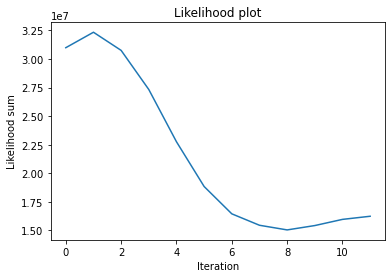

In [47]:
# Transpose df as gene is feature
algorithm2.fit(top100_df)
algorithm2.optimize()

#### The cluster converges to 3 points here

### 3) Latent_cluster :5,   Latent Variable: 10

In [48]:
algorithm3 = MFA(K=5,q=10,iteration=20)

Number of Latent cluster: 5, Number of Latent variable: 10


Sample Size: 72, Dimension Size: 100
Select random data points:  [41 35 21 26 55]
Iteration: 0
--------E STEP--------
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
--------M STEP--------
------- Cluster pi --------
Cluster 0: 0.36662071%
Cluster 1: 0.16947236%
Cluster 2: 0.18574062%
Cluster 3: nan%
Cluster 4: nan%
 
Iteration: 1
--------E STEP--------

----------Exception occured---------
----------Reinitialize Parameters---

Select random data points:  [30 43 63 13 21]
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
--------M STEP--------
------- Cluster pi --------
Cluster 0: 0.17115893%
Cluster 1: 0.12921771%
Cluster 2: 0.12559795%
Cluster 3: 0.38014224%
Cluster 4: 0.19388316%
 
Iteration: 2
--------E STEP--------
pdf_sum very small, adjusting...
pdf_

/home/ubuntu/anaconda3/envs/AIG_hw/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/home/ubuntu/anaconda3/envs/AIG_hw/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in true_divide


pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
--------M STEP--------
------- Cluster pi --------
Cluster 0: 0.00000092%
Cluster 1: 0.00002813%
Cluster 2: 0.00000031%
Cluster 3: 0.51328648%
Cluster 4: 0.48668416%
 
Iteration: 7
--------E STEP--------
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
--------M STEP--------
------- Cluster pi --------
Cluster 0: 0.00000001%
Cluster 1: 0.00000001%
Cluster 2: 0.00000001%
Cluster 3: 0.50435747%
Cluster 4: 0.49564249%
 
Iteration: 8
--------E STEP--------
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
--------M STEP--------
------- Cluster pi --------
Cluster 0: 0.00000001%
Cluster 1: 0.00000001%


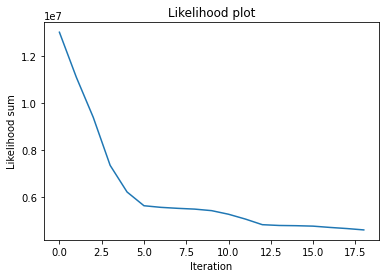

In [53]:
# Transpose df as gene is feature
algorithm3.fit(top100_df)
algorithm3.optimize()

### 4) Latent_cluster :10,   Latent Variable: 10

In [54]:
algorithm4 = MFA(K=10,q=10,iteration=10)

Number of Latent cluster: 10, Number of Latent variable: 10


Sample Size: 72, Dimension Size: 100
Select random data points:  [31 12 56  4 20 15 47 49 62 67]
Iteration: 0
--------E STEP--------
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
--------M STEP--------
------- Cluster pi --------
Cluster 0: 0.07791839%
Cluster 1: 0.10345013%
Cluster 2: 0.09804665%
Cluster 3: 0.07559143%
Cluster 4: 0.02935983%
Cluster 5: 0.13416046%
Cluster 6: 0.07371365%
Cluster 7: 0.16125368%
Cluster 8: 0.10442294%
Cluster 9: 0.14208284%
 
Iteration: 1
--------E STEP--------
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
pdf_sum very small, 

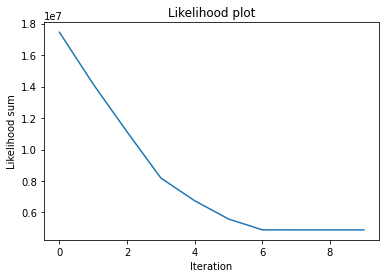

In [55]:
# Transpose df as gene is feature
algorithm4.fit(top100_df)
algorithm4.optimize()

#### -The cluster falls into 3 clusters

### There are explicit cases where we can see that the algorithm falls into local optima (Ofcourse, all converging points in MFA are not global)

Sample Size: 72, Dimension Size: 100
Select random data points:  [ 8 47 66 41 60 50  7 48  2 63]
Iteration: 0
--------E STEP--------
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
--------M STEP--------
------- Cluster pi --------
Cluster 0: 0.05918869%
Cluster 1: 0.13928945%
Cluster 2: 0.12507642%
Cluster 3: 0.08359056%
Cluster 4: 0.04981561%
Cluster 5: 0.07044140%
Cluster 6: 0.10692955%
Cluster 7: 0.13173789%
Cluster 8: 0.06948451%
Cluster 9: 0.16444592%
 
Iteration: 1
--------E STEP--------
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
pdf_sum very small, 

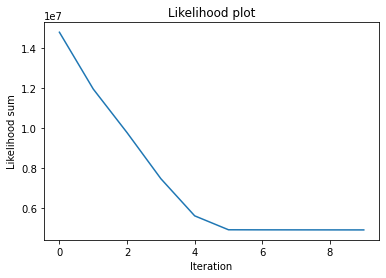

In [58]:
# Transpose df as gene is feature
algorithm4.fit(top100_df)
algorithm4.optimize()

In [59]:
## Extra Testing

In [60]:
# AS mentioned before, when cluster is 2, the algorithm does not converge. I tried with cluster 3, and found that most data points converge to 2 main clusters. The other one cluster has nearly 0 probability. 
# Below is an example. This intuition corresponds to the original data where there are two patient groups of AML and ALL patient 

Number of Latent cluster: 3, Number of Latent variable: 10
Sample Size: 72, Dimension Size: 100
Select random data points:  [20 40 32]
Iteration: 0
--------E STEP--------
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
--------M STEP--------
------- Cluster pi --------
Cluster 0: nan%
Cluster 1: nan%
Cluster 2: nan%
 
Iteration: 1
--------E STEP--------

----------Exception occured---------
----------Reinitialize Parameters---

Select random data points:  [42 64 44]
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
--------M STEP--------
------- Cluster pi --------
Cluster 0: nan%
Cluster 1: nan%
Cluster 2: nan%
 
Iteration: 2
--------E STEP--------

----------Exception occured---------
----------Reinitialize Parameters---

Select random data points:  [21 60 33]
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
--------M STEP--------
-----

/home/ubuntu/anaconda3/envs/AIG_hw/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/home/ubuntu/anaconda3/envs/AIG_hw/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in true_divide


--------M STEP--------
------- Cluster pi --------
Cluster 0: 0.45476878%
Cluster 1: nan%
Cluster 2: nan%
 
Iteration: 8
--------E STEP--------

----------Exception occured---------
----------Reinitialize Parameters---

Select random data points:  [12 56 71]
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
--------M STEP--------
------- Cluster pi --------
Cluster 0: 0.47052654%
Cluster 1: nan%
Cluster 2: nan%
 
Iteration: 9
--------E STEP--------

----------Exception occured---------
----------Reinitialize Parameters---

Select random data points:  [69  5 46]
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
pdf_sum very small, adjusting...
--------M STEP--------
------- Cluster pi --------
Cluster 0: nan%
Cluster 1: 0.33133782%
Cluster 2: 0.20814599%
 
Iteration: 10
--------E STEP--------

----------Exception occured---------
----------Reinitialize Parameters---

Select random data points:  [50 46 49]
pdf_sum very smal

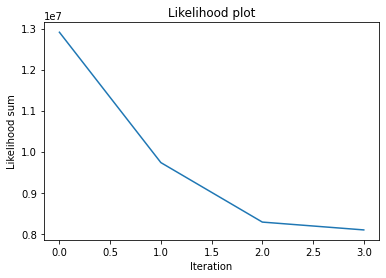

In [71]:
algorithm5 = MFA(K=3,q=10,iteration=20)
algorithm5.fit(top100_df)
algorithm5.optimize()